In [3]:
# Do not delete this cell. It ensures that you can do the imports,
# load datasets etc. in the same fashion as in any Python script
# in the project template.


import sys
sys.path.insert(0, '../..')
from bld.project_paths import project_paths_join as ppj
from bld.project_paths import project_paths as pp

%config Completer.use_jedi = False

#see https://github.com/yaroslavrosokha/sfem/blob/master/sfem.ipynb

In [2]:
import numpy as np
import json
import pickle
import pandas as pd
from scipy.stats import sem
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

%config Completer.use_jedi = False

# from matplotlib import rc
# rc('text', usetex=True)
# plt.rcParams.update({'font.size': 20})


In [4]:
data = pd.read_pickle(ppj("OUT_DATA", "data_individual_level.pickle"))

In [5]:
data_last_sg = data.loc[(data['super_game'] == 3) &
                             (data['treatment'] == '1H2A') ].copy()
# data_last_sg_1H2A = data.loc[(data['super_game'] == 1) &
#                              (data['treatment'] == '1H2A') ]

Reshape the data to wide format

In [6]:
data_subset = data_last_sg[['participant.code', 'round', 'price']]
data_subset_pivot = data_subset.pivot(index='participant.code', columns='round', values='price').copy()
data_subset_pivot.reset_index(level=0, inplace=True)


In [7]:
data_last_sg['ID'], _ = pd.factorize(data_last_sg['participant.code'])

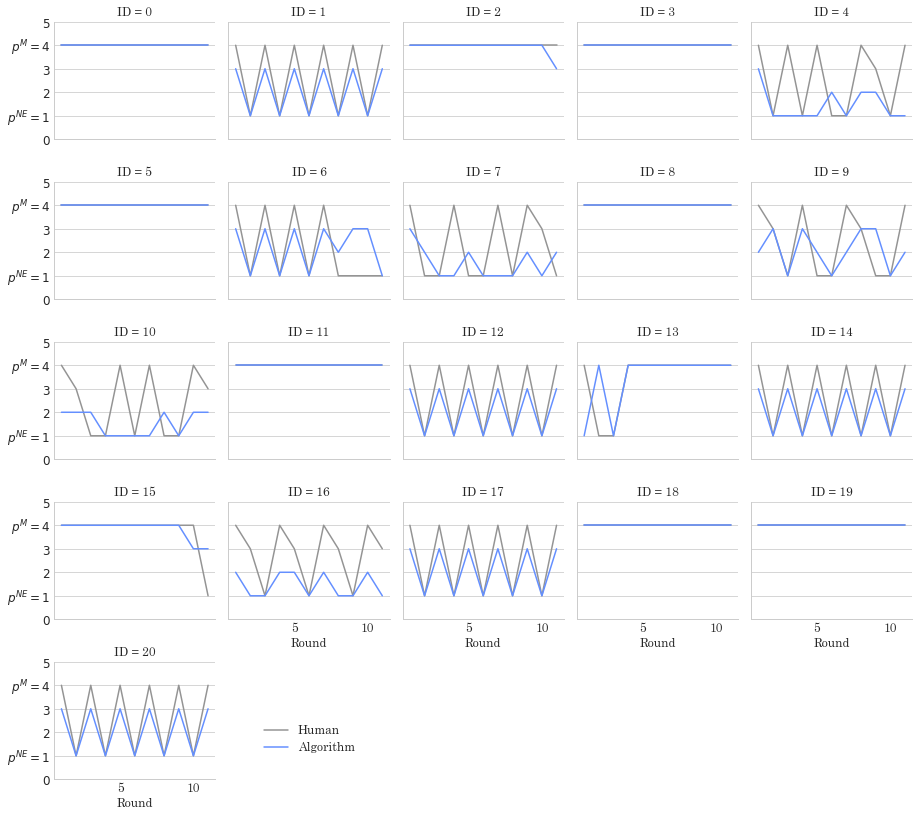

In [37]:
plt.style.use('seaborn-whitegrid')
mpl.rc('font', family='serif') 
mpl.rc('font', serif='Century') 
plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 12})    


g = sns.FacetGrid(data_last_sg, col="ID", col_wrap=5, height=2.3, aspect=1.1)
g.map(sns.lineplot, "round", "price_algorithm", color=sns.color_palette('colorblind')[7], label='Human')
g.map(sns.lineplot, "round", "price", color='#648FFF', label='Algorithm')
g.set(ylim=(0, 5), yticks=[0, 1, 2, 3,4,5], xticks=[5, 10])
g.set_yticklabels(["$0$", "$p^{NE}=1$", "$2$", "$3$", "$p^{M}=4$", "$5$"])
g.set_xlabels('Round')
g.set_ylabels('')
g.add_legend(bbox_to_anchor=(0.35, 0.1))
# g.legend.set
# , ncol=1)


for ax in g.axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.grid(False)


In [104]:
a =list(data_subset_pivot)

In [105]:
a.remove('participant.code')

In [106]:
def always_cooperate(p, p_lag_1, rounder_number):
    if p == 4:
        return 1
    else:
        return 0

def always_defect(p, p_lag_1, rounder_number):
    return 1 if p == 1 else 0

def exploit(p, p_lag_1, rounder_number):
    if p == 3 and p_lag_1 == 1:
        return 1
    elif p == 1 and p_lag_1 == 3:
        return 1
    elif rounder_number == 1 and p == 3:
        return 1
    else:
        return 0

In [107]:
def exploit_at_2(p, p_lag_1, rounder_number):
    if p == 2 and p_lag_1 == 1:
        return 1
    elif p == 1 and p_lag_1 == 2:
        return 1
    elif rounder_number == 1 and p == 2:
        return 1
    else:
        return 0

In [108]:
data_dal = data_last_sg[['participant.code', 'round', 'price', 'price_lag_1']].copy()

In [109]:
data_dal['ac'] = data_dal.apply(lambda x: always_cooperate(x['price'], x['price_lag_1'], x['round']), axis=1)

In [110]:
data_dal['ad'] = data_dal.apply(lambda x: always_defect(x['price'], x['price_lag_1'], x['round']), axis=1)

In [111]:
data_dal['exploit'] = data_dal.apply(lambda x: exploit(x['price'], x['price_lag_1'], x['round']), axis=1)

In [112]:
data_dal['exploit_at_2'] = data_dal.apply(lambda x: exploit_at_2(x['price'], x['price_lag_1'], x['round']), axis=1)

In [113]:
def likelihood_fun(data_i, beta, strat):
    all_vals = beta ** data_i[strat] * (1 - beta) ** (1 - data_i[strat])
    return np.prod(all_vals)

In [114]:
def log_likelihood(data, all_strat, all_phi, beta):
    val = 0
    for participant in data_dal['participant.code'].unique():
        current_data_i = data.loc[data['participant.code'] == participant]
        
        val_for_i = 0
        for current_phi, current_strat in zip(all_phi, all_strat):
            pr = likelihood_fun(current_data_i, beta, current_strat)
            val_for_i += current_phi * pr
        val += np.log(val_for_i)
    return val

In [115]:
def fun_to_min(all_x, all_strat, data):
    val = log_likelihood(data = data,
                         all_strat = all_strat,
                         all_phi=all_x[1:],
                         beta=all_x[0])
    return -val

In [116]:
from scipy.optimize import minimize

In [117]:
def constraint1(x):
    return x[1:].sum()-1
n_strats=4
#Set up the boundaries and constraints
b0 = (np.nextafter(0.5,1),1-np.nextafter(0,1))
b1 = (np.nextafter(0,1),1-np.nextafter(0,1))
bnds = tuple([b0]+[b1]*n_strats) #Beta is at least .5
con1 = {'type': 'eq', 'fun': constraint1} 
cons = ([con1])


In [118]:
bnds


((0.5000000000000001, 1.0),
 (5e-324, 1.0),
 (5e-324, 1.0),
 (5e-324, 1.0),
 (5e-324, 1.0))

In [119]:
#Some random starting point
x0 = np.zeros(n_strats+1)
x0[0] = .5+.5*np.random.random()
temp = np.random.random(n_strats)
x0[1:]=temp/temp.sum()

bestX=x0
bestObjective= -np.inf

for k in range(50): #Do many times so that there is low chance of getting stuck in local optimum
    print('moin')
    x0 = np.zeros(n_strats+1)
    x0[0] = .5+.5*np.random.random()
    temp = np.random.random(n_strats)
    x0[1:]=temp/temp.sum()

    #Notice that we are minimizing the negative
    solution = minimize(fun=fun_to_min, x0=x0, args=(['exploit', 'ac', 'ad', 'exploit_at_2'], data_dal),method='SLSQP',bounds=bnds,constraints=cons)
    x = solution.x
    obj = solution.fun

    if bestObjective>obj:
        bestObjective=obj
        bestX=x


moin


C:\Users\DICE\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)
C:\Users\DICE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin


In [120]:
x

array([0.85543352, 0.29755977, 0.47631373, 0.08922185, 0.13690465])

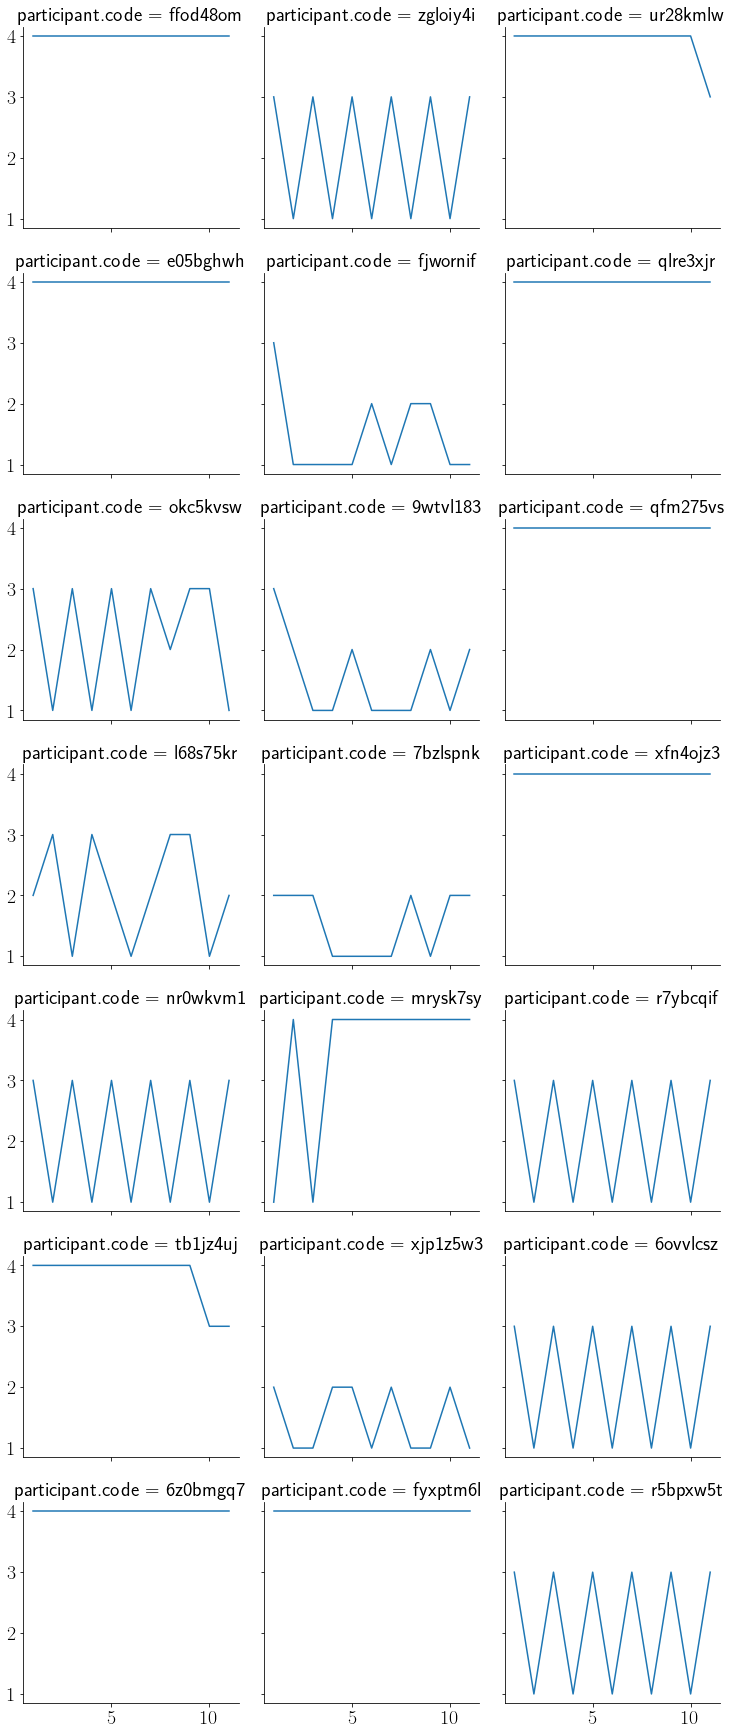

In [121]:
g = sns.FacetGrid(data_dal, col="participant.code", height=3.5, aspect=1, col_wrap=3)
g.map_dataframe(sns.lineplot, x="round", y="price")


In [122]:
data_dal

,participant.code,round,price,price_lag_1,ac,ad,exploit,exploit_at_2
462,ffod48om,1.0,4.0,NaN,1,0,0,0
463,zgloiy4i,1.0,3.0,NaN,0,0,1,0
464,ur28kmlw,1.0,4.0,NaN,1,0,0,0
465,e05bghwh,1.0,4.0,NaN,1,0,0,0
466,fjwornif,1.0,3.0,NaN,0,0,1,0
...,...,...,...,...,...,...,...,...
154,fyxptm6l,10.0,4.0,4.0,1,0,0,0
155,r5bpxw5t,10.0,1.0,3.0,0,1,1,0
156,6z0bmgq7,11.0,4.0,4.0,1,0,0,0
157,fyxptm6l,11.0,4.0,4.0,1,0,0,0
